<h1>Capstone Project - The Battle of Restaurant Location</h1>
</n>
<2> Wang Pan , July 2021

<h2>Part 1 - Problem and Background
   

<h3> Scenario: </h3>An optimistic invester is looking to start her restaurant business in Moncton (Moncton, Riverview, and Dieppe), New Brunswick, Canada. She is confident that her delicious cuisine and cozy dinning area will make her restaurant a great success. However, she is little worried about her starting budget, as she won't be able to decorate the restaurant up to her standard if she had to spend so much on advertisment. Thus, she would like to see some data in order to select a better location to start her restaurant.




<h3> Introduction: </h3> </n> The pandemic had a significant impact on catering industry. With the rate of vaccinated population growing up, some in Moncton, NB, CA, believe that it is time to make plan for opening their dream restuarant. Naturally, some useful data and graphics will make a huge difference for those people who have been wrestling to find the best restuarant location to suit their needs. </n> In this project, my goal is to be able to recommend resturant location by comparing then visualizing the difference of population and resident income, in different area/location in Moncton.



<h2> Part 2 - Data

Population Data from Statistics Canada: (2016)
https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=POPC&Code1=0539&Geo2=PR&Code2=13&SearchText=Moncton&SearchType=Begins&SearchPR=01&B1=All&GeoLevel=PR&GeoCode=0539&TABID=1&type=0


Population distribution in Moncton area (Moncton,Dieppe, Riverview)
https://www12.statcan.gc.ca/census-recensement/2016/as-sa/fogs-spg/Facts-CMA-Eng.cfm?TOPIC=1&LANG=Eng&GK=CMA&GC=305

Income Data from Statistics Canada: (2016)
https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=CMACA&Code1=305&Geo2=PR&Code2=13&SearchText=Moncton&SearchType=Begins&SearchPR=01&B1=Income&TABID=1&type=0

Median total income of households distribution (Moncton,Dieppe,Riverview)
https://www12.statcan.gc.ca/census-recensement/2016/as-sa/fogs-spg/Facts-cma-eng.cfm?LANG=Eng&GK=CMA&GC=305&TOPIC=6


Crime Data from Codiac Regional Policing Authority (2020 Q1-Q4)
https://crpa-aprc.ca/crpa/codiac-rcmp/quarterly-reports/

Crime Occurrence reports from Royal Canadian Mounted Police (Daily occurrence reports, New Brunswick occurrence map)
https://www.rcmp-grc.gc.ca/en/nb/home

I will first attempt to extract and normalize needed information from above listed sources then try to combine those information to map data from Foursquare API.</h5>




<h2>Part 3 - Data Analysis

In [1]:
# Importing tools that I will be using
from bs4 import BeautifulSoup
import requests
import pandas as pd
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import json
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import re

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
#Webscraping sites

#Population data
population_url= "https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=POPC&Code1=0539&Geo2=PR&Code2=13&SearchText=Moncton&SearchType=Begins&SearchPR=01&B1=All&GeoLevel=PR&GeoCode=0539&TABID=1&type=0"
population_data  = requests.get(population_url).text
population_soup= BeautifulSoup (population_data,"html5lib")
population_table= population_soup.find("table", {'class':'table table-condensed table-hover'})
population_table_data=population_table.tbody.findAll("tr")

#Population Distribution data
population_distribution_url="https://www12.statcan.gc.ca/census-recensement/2016/as-sa/fogs-spg/Facts-CMA-Eng.cfm?TOPIC=1&LANG=Eng&GK=CMA&GC=305"
population_distribution_data  = requests.get(population_distribution_url).text
population_distribution_soup= BeautifulSoup (population_distribution_data,"html5lib")
population_distribution_table= population_distribution_soup.find("table", {'class':'table-condensed span-6'})
population_distribution_table_data=population_distribution_table.tbody.findAll("tr")


#Income data
income_url= "https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=CMACA&Code1=305&Geo2=PR&Code2=13&SearchText=Moncton&SearchType=Begins&SearchPR=01&B1=Income&TABID=1&type=0"
income_data = requests.get(income_url).text
income_soup= BeautifulSoup (income_data,"html5lib")
income_table= income_soup.find("table", {'class':'table table-condensed table-hover'})
income_table_data=income_table.tbody.findAll("tr")


#Median income distribution data
median_income_url="https://www12.statcan.gc.ca/census-recensement/2016/as-sa/fogs-spg/Facts-cma-eng.cfm?LANG=Eng&GK=CMA&GC=305&TOPIC=6"
median_income_data  = requests.get(median_income_url).text
median_income_soup= BeautifulSoup (median_income_data,"html5lib")
median_income_table= median_income_soup.find("table", {'class':'table-condensed'})
median_income_table_data=median_income_table.tbody.findAll("tr")

In [4]:
#DataFrame display setting adjustment

def DF_option():
    pd.set_option('display.max_rows', None),
    pd.set_option('display.max_columns', None),
    pd.set_option('display.width', None),
    pd.set_option("max_colwidth", 100)

DF_option()

In [5]:
#Moncton Population Data web scraping
moncton_population_table=[]
for col in population_table_data:
    col["Characteristic"]=col.find_all('th')
    col["Total"]=col.find_all('td', {'headers':"total1"})
    col["Male"]=col.find_all('td',{'headers':'male1'})
    col["Female"]=col.find_all('td', {'headers':"female1"})
    
    col["Characteristic"]= [tr.text.strip() for tr in col['Characteristic']]
    col["Total"]= [tr.text.strip() for tr in col["Total"]]
    col["Male"]= [tr.text.strip() for tr in col["Male"]]
    col["Female"]= [tr.text.strip() for tr in col["Female"]]
    
    moncton_population_table.append([col["Characteristic"],col["Total"],col["Male"],col["Female"]])

df_population=pd.DataFrame(moncton_population_table)
df_population.columns=["Characteristic","Total","Male","Female"]
df_population=df_population.drop(df_population.index[42:])
df_population=df_population.drop(df_population.index[26:35])
df_population=df_population.drop(df_population.index[11:14])
df_population=df_population.drop(df_population.index[4:8])
df_population=df_population.reset_index(drop=True)
df_population

,Characteristic,Total,Male,Female
0,[Population and dwellings],[],[],[]
1,"[Population, 2016Census data footnote 1]","[108,620]",[...],[...]
2,"[Population, 2011Census data footnote 1]","[103,926 r]",[...],[...]
3,"[Population percentage change, 2011 to 2016]",[4.5],[...],[...]
4,[Age characteristics],[],[],[]
5,[Total - Age groups and average age of the population - 100% dataCensus data footnote 4],"[108,625]","[52,330]","[56,295]"
6,[0 to 14 years],"[17,245]","[8,875]","[8,375]"
7,[15 to 64 years],"[72,840]","[35,495]","[37,345]"
8,[15 to 19 years],"[5,890]","[2,985]","[2,905]"
9,[20 to 24 years],"[7,435]","[3,620]","[3,815]"


(<AxesSubplot:title={'center':'Moncton Population'}, xlabel='[Population by Age Groups]'>,
                                                                                  Characteristic  \
 Total  [Total - Age groups and average age of the population - 100% dataCensus data footnote 4]   
 0-14                                                                            [0 to 14 years]   
 15-64                                                                          [15 to 64 years]   
 65+                                                                         [65 years and over]   
 
         Total   Male  Female  
 Total  108625  52330   56295  
 0-14    17245   8875    8375  
 15-64   72840  35495   37345  
 65+     18540   7965   10575  )

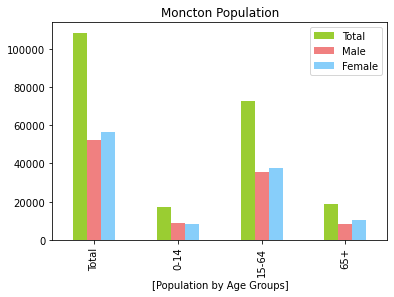

In [6]:
#Visualize Moncton Population Data

#Choosing needed data,normalizing data, and removing special characters from selected columns in the DataFrame
df_population_2= df_population.iloc[[5,6,7,18],0:4].reset_index(drop=True)

cols = ['Total','Male','Female']

for col in cols:
    df_population_2[col]= df_population_2[col].map(lambda x: str(x).lstrip('[').rstrip(']'))
    df_population_2[col]= df_population_2[col].str.replace(r'\D','').astype(int)              



df_population_2=df_population_2.rename(index={0:'Total',1:'0-14',2:'15-64',3:'65+'})

#Ploting the Bar Chart
colors_list = ['yellowgreen', 'lightcoral', 'lightskyblue']
labels=['Population by Age Groups']
df_population_bar=df_population_2.plot(kind='bar',
                    xlabel=labels,
                    title='Moncton Population',
                    color=colors_list)

df_population_bar, df_population_2
                

In [7]:
#Moncton Population Distribution Data web scraping
moncton_population_distribution_table=[]
for col in population_distribution_table_data:
    col["Name"]=col.find_all('th')
    col["2016"]=col.find_all('td', {'headers':"t1-col-2"})
    col["2011"]=col.find_all('td',{'headers':'t1-col-3'})
    col["%change"]=col.find_all('td', {'headers':"t1-col-4"})
    
    col["Name"]= [tr.text.strip() for tr in col['Name']]
    col["2016"]= [tr.text.strip() for tr in col["2016"]]
    col["2011"]= [tr.text.strip() for tr in col["2011"]]
    col["%change"]= [tr.text.strip() for tr in col["%change"]]
    
    moncton_population_distribution_table.append([col["Name"],col["2016"],col["2011"],col["%change"]])
df_population_distribution=pd.DataFrame(moncton_population_distribution_table)
df_population_distribution=df_population_distribution[df_population_distribution.index.isin([0,1,2])].reset_index(drop=True)
df_population_distribution

,0,1,2,3
0,"[Moncton Census subdivision - Moncton, City]","[71,889]","[69,074]",[4.1]
1,"[Dieppe Census subdivision - Dieppe, City]","[25,384]","[23,310]",[8.9]
2,"[Riverview Census subdivision - Riverview, Town]","[19,667]","[19,128]",[2.8]


(<AxesSubplot:title={'center':'Moncton Population Distribution'}, xlabel='[Population by Area]'>,
                                                   Area Name   2016   2011  \
 Moncton        [Moncton Census subdivision - Moncton, City]  71889  69074   
 Dieppe           [Dieppe Census subdivision - Dieppe, City]  25384  23310   
 Riverview  [Riverview Census subdivision - Riverview, Town]  19667  19128   
 
           %Change  
 Moncton       4.1  
 Dieppe        8.9  
 Riverview     2.8  )

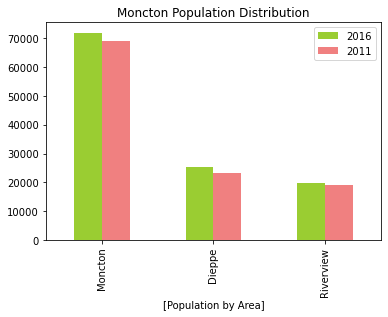

In [8]:
#Visualize Moncton Population Distribution Data

#Normalizing data and removing special characters from the dataframe
df_population_distribution=df_population_distribution.rename(columns={0:'Area Name',1:'2016', 2:'2011', 3:'%Change'}, 
                                                             index={0:'Moncton', 1:'Dieppe', 2:'Riverview'})
cols=['2016','2011','%Change']
int_cols=['2016','2011']
for col in cols:
    df_population_distribution[col]=df_population_distribution[col].map(lambda x: str(x).lstrip('[').rstrip(']'))
    
for int_col in int_cols:
    df_population_distribution[int_col]=df_population_distribution[int_col].str.replace(r'\D','').astype(int)
    
df_population_distribution["%Change"]=df_population_distribution["%Change"].str.replace('\'','')
df_population_distribution

#Ploting the Bar Chart
colors_list = ['yellowgreen', 'lightcoral']
labels=['Population by Area']
df_population_distribution_bar=df_population_distribution.plot(kind='bar',
                    xlabel=labels,
                    title='Moncton Population Distribution',
                    color=colors_list)

df_population_distribution_bar, df_population_distribution

In [9]:
#Moncton Income Data web scraping
moncton_income_table=[]
for col in income_table_data:
    col["Characteristic"]=col.find_all('th')
    col["Total"]=col.find_all('td', {'headers':"total1"})
    col["Male"]=col.find_all('td',{'headers':'male1'})
    col["Female"]=col.find_all('td', {'headers':"female1"})
    
    col["Characteristic"]= [tr.text.strip() for tr in col['Characteristic']]
    col["Total"]= [tr.text.strip() for tr in col["Total"]]
    col["Male"]= [tr.text.strip() for tr in col["Male"]]
    col["Female"]= [tr.text.strip() for tr in col["Female"]]
    
    moncton_income_table.append([col["Characteristic"],col["Total"],col["Male"],col["Female"]])

df_income=pd.DataFrame(moncton_income_table)
df_income.columns=["Characteristic","Total","Male","Female"]
df_income=df_income[df_income.index.isin([1,3,5,14,16])].reset_index(drop=True)
df_income

,Characteristic,Total,Male,Female
0,[Total - Income statistics in 2015 for the population aged 15 years and over in private househol...,"[118,825]","[57,280]","[61,550]"
1,[Median total income in 2015 among recipients ($)],"[33,587]","[39,174]","[28,770]"
2,[Median after-tax income in 2015 among recipients ($)],"[30,081]","[34,364]","[26,290]"
3,[Average total income in 2015 among recipients ($)],"[41,410]","[47,883]","[35,442]"
4,[Average after-tax income in 2015 among recipients ($)],"[34,614]","[39,239]","[30,351]"


(<AxesSubplot:title={'center':'Moncton Income'}, ylabel='[Moncton Income]'>,
                                                                                                                 Characteristic  \
 Total Population aged 15+  [Total - Income statistics in 2015 for the population aged 15 years and over in private househol...   
 Median Pre-Tax ($)                                                          [Median total income in 2015 among recipients ($)]   
 Median After-Tax ($)                                                    [Median after-tax income in 2015 among recipients ($)]   
 Avg Pre-Tax ($)                                                            [Average total income in 2015 among recipients ($)]   
 Avg After-Tax ($)                                                      [Average after-tax income in 2015 among recipients ($)]   
 
                             Total   Male  Female  
 Total Population aged 15+  118825  57280   61550  
 Median Pre-Tax ($)          33

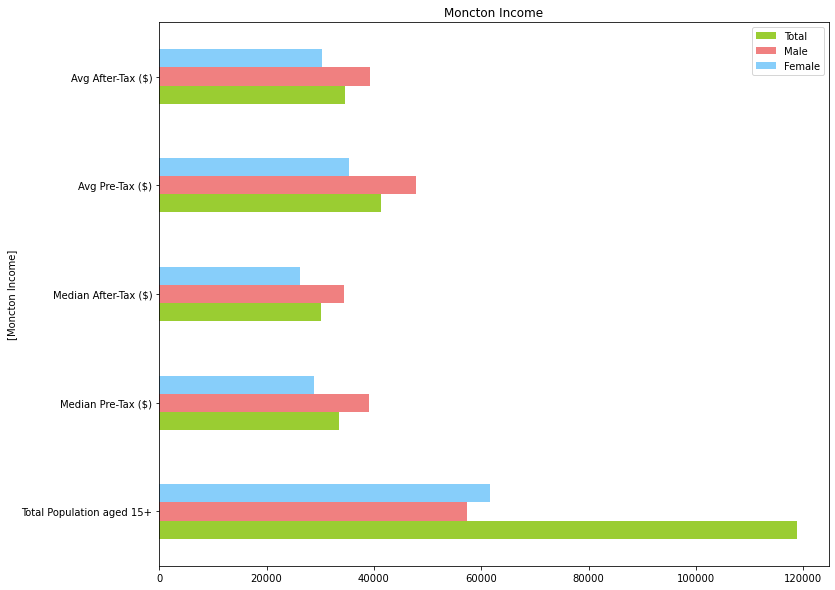

In [10]:
#Visualize Moncton Income Data

#Normalizing data and removing special characters from the dataframe
df_income=df_income.rename( index={0:'Total Population aged 15+', 
                                   1:'Median Pre-Tax ($)',
                                   2:'Median After-Tax ($)', 
                                   3:'Avg Pre-Tax ($)', 
                                   4:'Avg After-Tax ($)'})
cols = ['Total','Male','Female']

for col in cols:
    df_income[col]=df_income[col].map(lambda x: str(x).lstrip('[').rstrip(']'))
    df_income[col]=df_income[col].str.replace(r'\D','').astype(int)
df_income

#Ploting the Bar Chart

colors_list = ['yellowgreen', 'lightcoral', 'lightskyblue']
labels=['Moncton Income']
df_income_bar=df_income.plot(kind='barh',
                    ylabel=labels,
                    figsize=(12,10),
                    title='Moncton Income',
                    color=colors_list)
    

df_income_bar, df_income

In [11]:
#Moncton Median Income Distribution Data web scraping
moncton_median_income_table=[]
for col in median_income_table_data:
    col["Geography"]=col.find_all('th')
    col["2006"]=col.find_all('td', {'headers':"c2"})
    col["2016"]=col.find_all('td',{'headers':'c3'})
    col["%change"]=col.find_all('td', {'headers':"c4"})
    col["2005"]=col.find_all('td',{'headers':"c5"})
    col["2015"]=col.find_all('td',{'headers':"c6"})
    col["%_change"]=col.find_all('td',{'headers':"c7"})
    
    col["Geography"]= [tr.text.strip() for tr in col['Geography']]
    col["2006"]= [tr.text.strip() for tr in col["2006"]]
    col["2016"]= [tr.text.strip() for tr in col['2016']]
    col["%change"]= [tr.text.strip() for tr in col["%change"]]
    col["2005"]= [tr.text.strip() for tr in col['2005']]
    col["2015"]= [tr.text.strip() for tr in col['2015']]
    col["%_change"]= [tr.text.strip() for tr in col["%_change"]]
    moncton_median_income_table.append([col["Geography"],col["2006"],col["2016"],col["%change"], col["2005"], col["2015"], col["%_change"]])
    
df_median_income=pd.DataFrame(moncton_median_income_table)
df_median_income.columns=["Geography","2006","2016","%change","2005","2015","%_change"]


#df_median_income=df_median_income[df_median_income.index.isin({0,1,2,3,4})]   #The website table switches its order from time to time. Use this code when the table starts with Moncton (1)
df_median_income=df_median_income[df_median_income.index.isin({14,4,9,10,12})].reset_index(drop=True) #The website table switches its order from time to time. Use this code when the table starts with HopeWell
df_median_income


,Geography,2006,2016,%change,2005,2015,%_change
0,[Riverview (TV)],"[6,895]","[8,225]",[19.3],"[70,025]","[69,474]",[-0.8]
1,[Moncton (P)],"[3,325]","[3,880]",[16.7],"[66,248]","[74,240]",[12.1]
2,[Moncton (C)],"[27,680]","[32,135]",[16.1],"[53,205]","[56,062]",[5.4]
3,[Dieppe (C)],"[7,145]","[10,285]",[43.9],"[75,204]","[76,963]",[2.3]
4,[Moncton (1)],"[51,905]","[61,770]",[19.0],"[59,549]","[62,871]",[5.6]


As we can see from the table above, Moncton has been seperated into Moncton Perish, Moncton City and Moncton, which is unnecessary for our case. For the sake of consistency of this project, we will combine the three Moncton data into one in the next code section 

(<AxesSubplot:title={'center':'Moncton Income Distribution Data'}, ylabel='[Moncton Income]'>,
                 Geography  2006 # of Household  2016 # of Household %change  \
 Moncton           Moncton                82910                97785    17.9   
 Riverview  Riverview (TV)                 6895                 8225    19.3   
 Dieppe         Dieppe (C)                 7145                10285    43.9   
 
            2005 Household median income  2015 Household median income %_change  
 Moncton                           59667                         64391      7.9  
 Riverview                         70025                         69474     -0.8  
 Dieppe                            75204                         76963      2.3  )

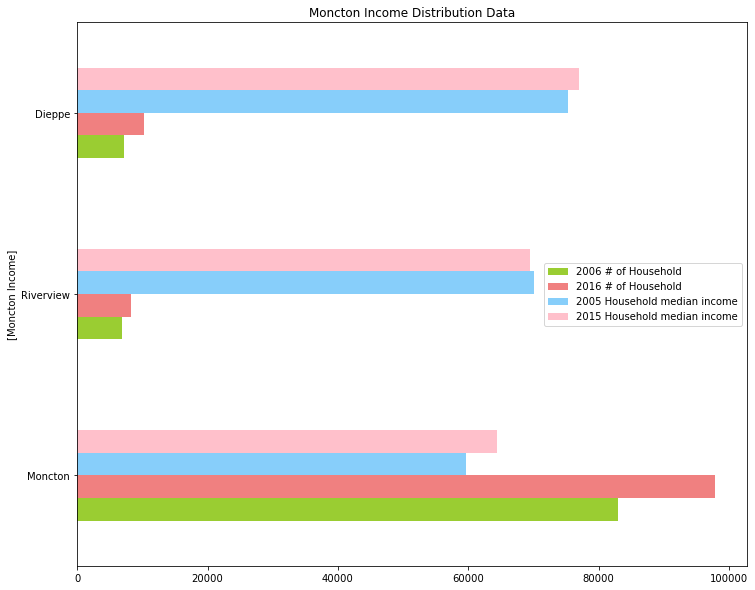

In [12]:
#Visualize Moncton Median Income Distribution Data

#Choosing needed data, normalizing data, and removing special characters from dataframe

cols= ['Geography','2006','2016','%change','2005','2015','%_change']
int_cols=['2006','2016','2005','2015']
percent_cols= ['Geography','%change','%_change']
for col in cols:
    df_median_income[col]=df_median_income[col].map(lambda x: str(x).lstrip('[').rstrip(']'))

for int_col in int_cols:
    df_median_income[int_col]=df_median_income[int_col].str.replace(r'\D','').astype(int)
for percent_col in percent_cols:
    df_median_income[percent_col]=df_median_income[percent_col].str.replace('\'','')

# Combine Three Moncton data into One
df_median_income_moncton=df_median_income[df_median_income['Geography'].str.contains('on', regex=True)]
df_median_income_moncton
sum_row= pd.Series(['Moncton',
                    df_median_income_moncton['2006'].sum(),
                    df_median_income_moncton['2016'].sum(),
                    round(df_median_income_moncton['2016'].sum()/ df_median_income_moncton['2006'].sum() *100-100,1),
                    int(df_median_income_moncton['2005'].sum()/3),
                    int(df_median_income_moncton['2015'].sum()/3),
                    round(df_median_income_moncton['2015'].sum()/ df_median_income_moncton['2005'].sum() *100-100,1)])

row_df=pd.DataFrame([sum_row],index=['Moncton']) 
row_df=row_df.rename(columns={0:'Geography',1:'2006',2:'2016',3:'%change',4:'2005',5:'2015',6:'%_change'})

df_median_income=pd.concat([row_df,df_median_income])
df_median_income=df_median_income[df_median_income.index.isin(['Moncton',0,3])] #choosing needed data  #adjust 0 to 1, 3 to 4, if the website table starts with Moncton(1) otherwise 0 and 3
df_median_income=df_median_income.rename(columns= {'2006':'2006 # of Household', 
                                                   '2016': '2016 # of Household', 
                                                   '2005':'2005 Household median income', 
                                                   '2015':'2015 Household median income'}, 
                                         index={0:'Riverview',3:'Dieppe'}) #rename columns and indexes #adjust 0 to 1, 3 to 4, if the website table starts with Moncton(1) otherwise 0 and 3

#Ploting the bar chart

colors_list = ['yellowgreen', 'lightcoral', 'lightskyblue', 'pink']
df_median_income_bar=df_median_income.plot(kind='barh',
                                           ylabel=labels,
                                           figsize=(12,10),
                                           title='Moncton Income Distribution Data',
                                           color=colors_list,
                                          )

df_median_income_bar, df_median_income




Here are some information we can get from the chart,
    The population of Moncton Area (Moncton, Riverview, and Dieppe) has grown between 2006 and 2016. 
    The median income for Dieppe is higher than Riverview, and Riverview is higher than Moncton.
    Over 80% of population lives in Moncton. 

We have seen enough population and income data for Moncton area to this point. Now I will retrive Restaurants and Parking information from Foursquare API 

In [13]:
#Getting Moncton Latitute and longitude
address= 'Downtown Moncton, NB'
dm_geolocator = Nominatim(user_agent="dm_explorer")
dm_location = dm_geolocator.geocode(address)
dm_latitude = dm_location.latitude 
dm_longitude = dm_location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,dm_latitude, dm_longitude))
#Moncton map with folium
Downtown_Moncton_map= folium.Map(location=[dm_latitude, dm_longitude], zoom_start=12)

The geograpical coordinate of Downtown Moncton, NB are 46.091638, -64.777895.


In [14]:
#setting up Foursquare API searching 
CategoryID= "4d4b7105d754a06374d81259" #Foursquare API ID for Food
radius =10000
print('Searching all catering businesses within radius {} m' .format(radius))

Searching all catering businesses within radius 10000 m


In [15]:
#URL
url='https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, dm_latitude, dm_longitude,ACCESS_TOKEN, VERSION, CategoryID,  radius, LIMIT)

In [16]:
results = requests.get(url).json()
results
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]



<ipython-input-16-32d138b06c90>:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

Moncton_restaurant=dataframe_filtered

Moncton_restaurant




,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Calactus cafe restaurant,Vegetarian / Vegan Restaurant,125 Church Street,46.092017,-64.779120,"[{'label': 'display', 'lat': 46.09201712678155, 'lng': -64.77912011656535}]",103,E1C,CA,Moncton,NB,Canada,"[125 Church Street, Moncton NB E1C]",NaN,4b72e2c8f964a5207c8d2de3
1,Euston Park Social,Beer Garden,5 Euston St,46.082230,-64.783046,"[{'label': 'display', 'lat': 46.08223, 'lng': -64.783046}]",1120,E1C 5S1,CA,Moncton,NB,Canada,"[5 Euston St (Waterloo), Moncton NB E1C 5S1]",Waterloo,5ced9402f2554e002cbd8dc2
2,Gusto Italian Grill & Bar,Italian Restaurant,130 Westmorland St,46.087905,-64.778462,"[{'label': 'display', 'lat': 46.087905, 'lng': -64.778462}]",417,E1C 1G2,CA,Moncton,NB,Canada,"[130 Westmorland St, Moncton NB E1C 1G2]",NaN,53dc0b92498e22feae3c995b
3,Carrabba's Italian Grill,Italian Restaurant,1000 Main St,46.086575,-64.783410,"[{'label': 'display', 'lat': 46.086575, 'lng': -64.78341}]",706,E1C 1G9,CA,Moncton,NB,Canada,"[1000 Main St (main and Canada), Moncton NB E1C 1G9]",main and Canada,6059ecca23d69327f5310e69
4,St Louis Bar and Grill,Wings Joint,NaN,46.112237,-64.833602,"[{'label': 'display', 'lat': 46.112236932646375, 'lng': -64.8336016757737}]",4873,NaN,CA,Moncton,NB,Canada,[Moncton NB],NaN,515f1038e4b0affc27905088
5,Cafe C'est La Vie,Café,Main Street,46.088264,-64.778449,"[{'label': 'display', 'lat': 46.088264128107866, 'lng': -64.77844887661162}]",378,NaN,CA,Moncton,NB,Canada,"[Main Street, Moncton NB]",NaN,508acd09e4b07c9fb0349075
6,Chatime,Bubble Tea Shop,125 Main Street,46.093629,-64.765926,"[{'label': 'display', 'lat': 46.093629, 'lng': -64.765926}]",950,NaN,CA,Moncton,NB,Canada,"[125 Main Street, Moncton NB]",NaN,5a81e1be2105c366071a1fc1
7,Pur & Simple,Restaurant,"477 Paul Street, Dieppe, NB, E1A 4X5",46.095990,-64.759476,"[{'label': 'display', 'lat': 46.09599, 'lng': -64.759476}]",1502,E1A 5R4,CA,Dieppe,NB,Canada,"[477 Paul Street, Dieppe, NB, E1A 4X5, Dieppe NB E1A 5R4]",NaN,5cf144b13ba767002cfbbebf
8,Skipper Jack's,Seafood Restaurant,211 Mapleton Rd,46.113386,-64.824808,"[{'label': 'display', 'lat': 46.1133859077467, 'lng': -64.82480764389038}]",4355,NaN,CA,Moncton,NB,Canada,"[211 Mapleton Rd, Moncton NB]",NaN,4bd85e6c09ecb71307a3487c
9,Deluxe Fish & Chips,Fast Food Restaurant,NaN,46.115323,-64.772814,"[{'label': 'display', 'lat': 46.115323, 'lng': -64.772814}]",2665,NaN,CA,Moncton,NB,Canada,[Moncton NB],NaN,4dc06c1dcda12687c84a9840


Although Moncton is one of the big cities located in New Brunswick, Canada, we are not getting thousands of results as we would for if searching cities like New York or Toronto. However, we may still find something interesting with this relatively small dataset.
    By looking at the restaurant list, we may see that our client's restaurant could be a great success as there are enough diversity in the city while there are not that many restaurants offering similar cusine. Therefore, the client probably won't need to worry too much about having a competitor offering similar food at nearby location.
    And since our goal is to make recommendations for restaurant location in general instead of for certain kind of restaurant (eg. Italian food, Japanese food, Mexican food, and etc), we can re-categorize the restaurants into following categories based on the amount of time the customers would spend in the restaurat. The categories we are going to use are, Fast Food Restaurant, Restaurant, Coffee Shop, or Other. 
    

In [18]:
#Replacing Categories

for i in Moncton_restaurant['categories']:
    if i in ['Fast Food Restaurant', 'Pizza Place', 'Sandwich Place']:
        Moncton_restaurant['categories'].replace({i:'Fast Food Restaurant'}, inplace=True)
    elif i in ['Coffee Shop', 'Café', 'Bubble Tea Shop','Brewery']:
        Moncton_restaurant['categories'].replace({i:'Coffee Shop'}, inplace=True)
    elif i in ['Vegetarian / Vegan Restaurant', 'Restaurant','Japanese Restaurant', 'Italian Restaurant','Wings Joint','Seafood Restaurant','American Restaurant','Falafel Restaurant','Indian Restaurant','Breakfast Spot']:
        Moncton_restaurant['categories'].replace({i:'Restaurant'}, inplace=True)
    else:
        Moncton_restaurant['categories'].replace({i:'Other'}, inplace=True)
Moncton_restaurant

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Calactus cafe restaurant,Restaurant,125 Church Street,46.092017,-64.779120,"[{'label': 'display', 'lat': 46.09201712678155, 'lng': -64.77912011656535}]",103,E1C,CA,Moncton,NB,Canada,"[125 Church Street, Moncton NB E1C]",NaN,4b72e2c8f964a5207c8d2de3
1,Euston Park Social,Other,5 Euston St,46.082230,-64.783046,"[{'label': 'display', 'lat': 46.08223, 'lng': -64.783046}]",1120,E1C 5S1,CA,Moncton,NB,Canada,"[5 Euston St (Waterloo), Moncton NB E1C 5S1]",Waterloo,5ced9402f2554e002cbd8dc2
2,Gusto Italian Grill & Bar,Restaurant,130 Westmorland St,46.087905,-64.778462,"[{'label': 'display', 'lat': 46.087905, 'lng': -64.778462}]",417,E1C 1G2,CA,Moncton,NB,Canada,"[130 Westmorland St, Moncton NB E1C 1G2]",NaN,53dc0b92498e22feae3c995b
3,Carrabba's Italian Grill,Restaurant,1000 Main St,46.086575,-64.783410,"[{'label': 'display', 'lat': 46.086575, 'lng': -64.78341}]",706,E1C 1G9,CA,Moncton,NB,Canada,"[1000 Main St (main and Canada), Moncton NB E1C 1G9]",main and Canada,6059ecca23d69327f5310e69
4,St Louis Bar and Grill,Restaurant,NaN,46.112237,-64.833602,"[{'label': 'display', 'lat': 46.112236932646375, 'lng': -64.8336016757737}]",4873,NaN,CA,Moncton,NB,Canada,[Moncton NB],NaN,515f1038e4b0affc27905088
5,Cafe C'est La Vie,Coffee Shop,Main Street,46.088264,-64.778449,"[{'label': 'display', 'lat': 46.088264128107866, 'lng': -64.77844887661162}]",378,NaN,CA,Moncton,NB,Canada,"[Main Street, Moncton NB]",NaN,508acd09e4b07c9fb0349075
6,Chatime,Coffee Shop,125 Main Street,46.093629,-64.765926,"[{'label': 'display', 'lat': 46.093629, 'lng': -64.765926}]",950,NaN,CA,Moncton,NB,Canada,"[125 Main Street, Moncton NB]",NaN,5a81e1be2105c366071a1fc1
7,Pur & Simple,Restaurant,"477 Paul Street, Dieppe, NB, E1A 4X5",46.095990,-64.759476,"[{'label': 'display', 'lat': 46.09599, 'lng': -64.759476}]",1502,E1A 5R4,CA,Dieppe,NB,Canada,"[477 Paul Street, Dieppe, NB, E1A 4X5, Dieppe NB E1A 5R4]",NaN,5cf144b13ba767002cfbbebf
8,Skipper Jack's,Restaurant,211 Mapleton Rd,46.113386,-64.824808,"[{'label': 'display', 'lat': 46.1133859077467, 'lng': -64.82480764389038}]",4355,NaN,CA,Moncton,NB,Canada,"[211 Mapleton Rd, Moncton NB]",NaN,4bd85e6c09ecb71307a3487c
9,Deluxe Fish & Chips,Fast Food Restaurant,NaN,46.115323,-64.772814,"[{'label': 'display', 'lat': 46.115323, 'lng': -64.772814}]",2665,NaN,CA,Moncton,NB,Canada,[Moncton NB],NaN,4dc06c1dcda12687c84a9840


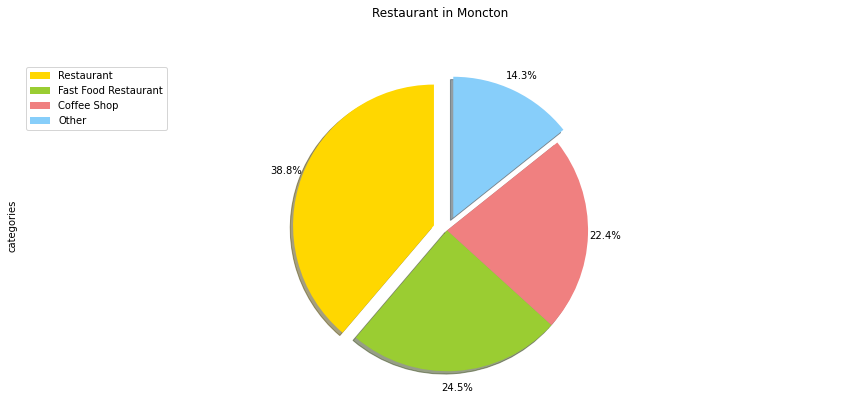

In [19]:
#Visualizing type of restaurant
Moncton_restaurant_count=Moncton_restaurant["categories"].value_counts()

#Ploting the Pie Chart

colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode_list = [0.1, 0, 0,  0.1] # ratio for each continent with which to offset each wedge.

Moncton_restaurant_count.plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         
                            pctdistance=1.12,   
                            colors=colors_list,  
                            explode=explode_list,
                            )

plt.title('Restaurant in Moncton', y=1.12) 
plt.axis('equal') 
# add legend
plt.legend(labels=Moncton_restaurant_count.index, loc='upper left') 
plt.show()

We can now easily see that Fast Food Restaurant (such as Macdonld's ,KFC, Subway, Pizza Hut, and etc) is playing a critical role in the catering industry in Moncton, and so does Coffee Shop. Now, it is time to see the restaurant's distribution on the map. We will mark the four categories by Dark red, light coral, green, and light green; where Restaurants are marked in dark red meaning customers will spend more time when dinning in such places, Coffee Shops in light coral meaning customers will spend relatively longer time, Fast Food Restaurants in green meaning customers don't need to spend too much time when dinning in such places, and Other in light green meaning the time is unpredictable.

In [20]:
#Marking restaurant locations on Downtown_Moncton_map

for lat, lng, name, categories in zip(Moncton_restaurant['lat'],Moncton_restaurant['lng'],Moncton_restaurant['name'],Moncton_restaurant['categories']):
    
    if categories in ('Restaurant'): #Restaurants will be marked on the map in gold color
        label='{}, {}'.format(name, categories)
        label=folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(Downtown_Moncton_map)
    elif categories in ('Fast Food Restaurant'): #Fast Food Restaurants will be marked on the map in yellowgreen color
        label='{}, {}'.format(name, categories)
        label=folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(Downtown_Moncton_map)
    elif categories in ('Coffee Shop'): # Coffee Shop will be marked on the map in lightcoral color
        label='{}, {}'.format(name, categories)
        label=folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='lightcoral',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(Downtown_Moncton_map)
    else: #Other, such as superstore, will be marked on the map in blue color
        label='{}, {}'.format(name, categories)
        label=folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='lightgreen',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(Downtown_Moncton_map)
Downtown_Moncton_map

From the map we can see:
 Most restaurants are located along the two sides of Mountain Road and Main Street or around the Champlain Place Mall.
 Most restaurants are located in Moncton and in between of Moncton and Dieppe.
 We can also see something interesting here, there are no Fast Food Restaurants (Dark green) located in the downtown Moncton area while a good amount of restaurants (Dark red) and coffee shops (Light Coral) are located in downtown Moncton.
 Since we know customers will spend more time in restaurants and in coffee shops than the time they will spend in fast food restaurants, parking lot distribution would also be something worth looking into.

In [21]:
#Requesting parking lot location from Foursquare API
CategoryID= "4c38df4de52ce0d596b336e1" #Foursquare API ID for Parking
radius =10000
print('Searching all catering businesses within radius {}m' .format(radius))


Searching all catering businesses within radius 10000m


In [22]:
url='https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, dm_latitude, dm_longitude,ACCESS_TOKEN, VERSION, CategoryID,  radius, LIMIT)

In [23]:
results = requests.get(url).json()
results
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

Moncton_parking=dataframe_filtered

Moncton_parking

<ipython-input-23-ba7b70ac6d2d>:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,name,categories,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,id
0,Parking Garage,Parking,46.089540,-64.777080,"[{'label': 'display', 'lat': 46.08954, 'lng': -64.77708}]",241,CA,Moncton,NB,Canada,[Moncton NB],5048b885e4b0c23df1be07ba
1,CRA parking lot,Parking,46.091376,-64.771438,"[{'label': 'display', 'lat': 46.091375842514715, 'lng': -64.77143837704602}]",499,CA,Moncton,NB,Canada,[Moncton NB],4f06ecbfe4b090ef204445b5
2,Balcone,Parking,46.110674,-64.777299,"[{'label': 'display', 'lat': 46.110674, 'lng': -64.777299}]",2119,CA,Moncton,NB,Canada,[Moncton NB],4eb9dfcc02d5860f8552c22d


In [24]:
#Marking Parking locations on Downtown_Moncton_map

for lat, lng, name, categories in zip(Moncton_parking['lat'],Moncton_parking['lng'],Moncton_parking['name'],Moncton_parking['categories']):
    label='{}, {}'.format(name, categories)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    location=[lat,lng],
    radius=4,
    popup=label,
    color='black',
    fill=True,
    fill_color='purple',
    fill_opacity=0.7,
    parse_html=False).add_to(Downtown_Moncton_map)
    
Downtown_Moncton_map

We can see three parking lot results were found from Foursquare API, and two parking lots are located in downtown Moncton.
    

<h2>Part 4 - Result </h2>
Our findings show that Moncton (Moncton, Riverview, and Dieppe) is a steadily expanding city (population) with average after-tax income for individual at \$34,614 (2015) and median after-tax income for individual at \$30,081 respectively.
The city has a various kind of restaurants competing with each other while most of the restaurants don't have many competitors offering same or similar kind of cusines.
Most restaurants (regular restaurants, fast food restaurants, and coffee shops) are located in Moncton or in the middle of Moncton and Dieppe. And many restaurants are located close to each other, thus formed several dinning spots in the city. 
Most fast food restaurants are located along the sides of Mountain Road or near the Champlain Place Mall, while most restaurants (regular) are loacted in downtown Moncton where parking lots are frequently seen.

<h2>Part 5 - Conclusion </h2>

Depending on what type of restaurant the stakeholder would like to open, the restaurant location varies. Since Moncton don't have as many restaurants as in metropolises, the stakeholder could use the information to either open his/her restaurant at a distance from other restaurants or open the restaurant within one of the exisitng dinning areas. 
   